In [1]:
import fermi.tipsh as tipsh
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from astropy.visualization.wcsaxes.frame import EllipticalFrame
import pywt
import numpy
import math
from scipy.optimize import minimize
import os

os.system("taskset -p 0xff %d" % os.getpid())

pid 6346's current affinity mask: ff
pid 6346's new affinity mask: ff


0

In [2]:
data_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_ccube.fits')
cmap_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_cmap.fits')
model_file = get_pkg_data_filename('allsky_counts_model.fits')
diffuse_model_file = get_pkg_data_filename('diffuse_only.fits')
#model2_file = get_pkg_data_filename('allsky_counts_ultraclean.fits')
point_model1_file = get_pkg_data_filename('point_only_0_6938_model.fits')
point_model2_file = get_pkg_data_filename('point_only_6939_14007_model.fits')
point_model3_file = get_pkg_data_filename('point_only_14008_20004_model.fits')
point_model4_file = get_pkg_data_filename('point_only_20005_29999_model.fits')
point_model5_file = get_pkg_data_filename('point_only_30000_40010_model.fits')
point_model6_file = get_pkg_data_filename('point_only_40011_50004_model.fits')
point_model7_file = get_pkg_data_filename('point_only_50005_59998_model.fits')
point_model8_file = get_pkg_data_filename('point_only_59999_model.fits')
exp_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_expcube1.fits')

In [3]:
data_hdu = fits.open(cmap_file)[0]
wcs = WCS(data_hdu.header)

In [4]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [5]:
count_data = fits.getdata(data_file, ext=0)[0]
#cmap_data = fits.getdata(cmap_file, ext=0)
#count_model = fits.getdata(model_file, ext=0)
diffuse_model = fits.getdata(diffuse_model_file, ext=0)[0]
#count_model2 = fits.getdata(model2_file, ext=0)[0]
point_model1 = fits.getdata(point_model1_file, ext=0)[0]
point_model2 = fits.getdata(point_model2_file, ext=0)[0]
point_model3 = fits.getdata(point_model3_file, ext=0)[0]
point_model4 = fits.getdata(point_model4_file, ext=0)[0]
point_model5 = fits.getdata(point_model5_file, ext=0)[0]
point_model6 = fits.getdata(point_model6_file, ext=0)[0]
point_model7 = fits.getdata(point_model7_file, ext=0)[0]
point_model8 = fits.getdata(point_model8_file, ext=0)[0]
#model_data = numpy.vectorize(poisson.rvs)(model_expected)
exp_data = fits.getdata(exp_file, ext=0)[1]
#model_norm = model_data - numpy.min(model_data)

In [6]:
point_model = numpy.add(point_model1, point_model2)
point_model = numpy.add(point_model, point_model3)
point_model = numpy.add(point_model, point_model4)
point_model = numpy.add(point_model, point_model5)
point_model = numpy.add(point_model, point_model6)
point_model = numpy.add(point_model, point_model7)
point_model = numpy.add(point_model, point_model8)
total_model = numpy.add(point_model, diffuse_model)

In [7]:
dnorm = sum(sum(diffuse_model))
d = diffuse_model/dnorm
p1norm = sum(sum(point_model1))
p1 = point_model1/p1norm
p2norm = sum(sum(point_model2))
p2 = point_model2/p2norm
p3norm = sum(sum(point_model3))
p3 = point_model3/p3norm
p4norm = sum(sum(point_model4))
p4 = point_model4/p4norm
p5norm = sum(sum(point_model5))
p5 = point_model5/p5norm
p6norm = sum(sum(point_model6))
p6 = point_model6/p6norm
p7norm = sum(sum(point_model7))
p7 = point_model7/p7norm
p8norm = sum(sum(point_model8))
p8 = point_model8/p8norm

In [8]:
def image_dot(i1, i2):
    return sum(sum(numpy.multiply(i1, i2)))

In [9]:
def image_conv(z, psfs):
    r = numpy.zeros(psfs[0].shape)
    for i in range(len(z)):
        r = numpy.add(r, z[i]*psfs[i])
    return r

In [10]:
def rl1(psfs, z, data):
    im0 = image_conv(z, psfs)
    rat = numpy.divide(data, im0)
    zk = [0]*len(z)
    for i in range(len(z)):
        zk[i] = z[i]*image_dot(rat, psfs[i])
    return zk

In [11]:
def loss_map(psfs, z, data):
    im0 = image_conv(z, psfs)
    return numpy.subtract(im0, numpy.multiply(data, numpy.log(im0)))
def d2_loss_map(psfs, z, data):
    im0 = image_conv(z, psfs)
    return numpy.square(numpy.subtract(data, im0))
def loss(psfs, z, data, loss_map):
    return sum(sum(loss_map(psfs, z, data)))

In [12]:
def fz(z):
    return loss(psfs, z, count_data, d2_loss_map)

In [13]:
z0 = [dnorm, p1norm, p2norm, p3norm, p4norm, p5norm, p6norm, p7norm, p8norm]
psfs = [d, p1, p2, p3, p4, p5, p6, p7, p8]
zk = z0

In [14]:
zk = rl1(psfs, zk, count_data)
#[i / j for i,j in zip(zk, z0)]
zk

[27902803.729612503,
 340010.78922408936,
 352624.77501940134,
 237194.48669260505,
 768164.902712078,
 966280.1741660566,
 1342689.2138193755,
 464905.08295419783,
 193526.19630233973]

In [78]:
zknm = minimize(fz, zk, method='Nelder-Mead')
zknm

 final_simplex: (array([[26030337.10626683,   516065.72230582,   521441.58688954,
          339397.63281673,  1181020.65751283,  1543238.07187989,
         1895126.24691964,   554506.14291797,   247731.48185195],
       [26030337.21621349,   516065.70895866,   521441.57951271,
          339397.61531033,  1181020.66454896,  1543238.07082025,
         1895126.24216906,   554506.11322538,   247731.47724786],
       [26030337.32956553,   516065.72335156,   521441.57935747,
          339397.6089182 ,  1181020.66841951,  1543238.07042778,
         1895126.24446563,   554506.13621506,   247731.48953441],
       [26030337.36826224,   516065.70782256,   521441.60324407,
          339397.61841481,  1181020.66959419,  1543238.07078877,
         1895126.24600066,   554506.13002764,   247731.51103009],
       [26030337.17965942,   516065.72891263,   521441.5885785 ,
          339397.63532993,  1181020.67023802,  1543238.0726783 ,
         1895126.2441339 ,   554506.10515224,   247731.49814892],
   

In [17]:
zfoo = [i*f for i, f in zip([26030337.10626683,   516065.72230582,   521441.58688954,
         339397.63281673,  1181020.65751283,  1543238.07187989,
        1895126.24691964,   554506.14291797,   247731.48185195], [0.98, 0.45, 0.6, 0.5, 0.5, 0.375, 0.45, 0.4, 0.5])]
#loss(psfs, zfoo, count_data, loss_map)
im0 = image_conv(zfoo, psfs)
total_model = im0

In [15]:
def imshow_mollweide(data, cmap, norm):
    fig = plt.figure(figsize=(30, 15))
    ax = plt.subplot(projection=ccrs.Mollweide())
    #diff = plt.imshow(fits.getdata(data_file, ext=0), origin='lower')
    diff = ax.imshow(data, cmap=cmap, origin='lower', norm=norm, transform=ccrs.PlateCarree(), extent=(-180,180,-90,90))
    #ax.grid(color='black')
    #diff = plt.imshow(im0, cmap=plt.cm.viridis, origin='lower', norm=colors.LogNorm())
    plt.colorbar(diff)
    return fig, ax

(<Figure size 2160x1080 with 2 Axes>, <GeoAxesSubplot:>)

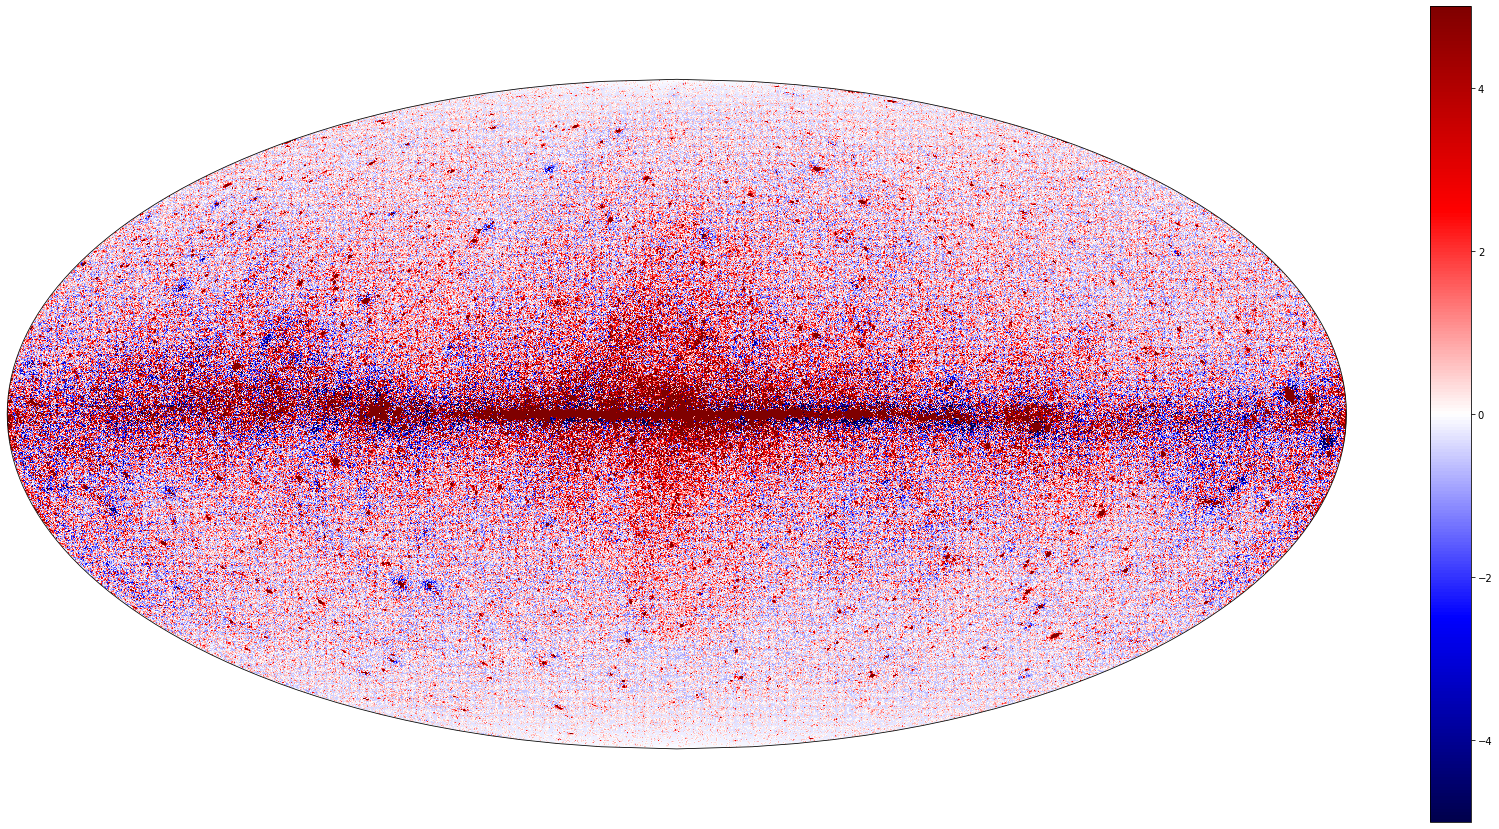

In [18]:
#print(loss(psfs, zk, count_data, d2_loss_map))
#fig = plt.figure(figsize=(30, 15))
#ax = plt.subplot(projection=ccrs.Mollweide())
#diff = plt.imshow(fits.getdata(data_file, ext=0), origin='lower')
#diff = ax.imshow(numpy.subtract(count_data, im0), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5), transform=ccrs.PlateCarree(), extent=(-90,90,-180,180))
#ax.grid(color='black')
#diff = plt.imshow(im0, cmap=plt.cm.viridis, origin='lower', norm=colors.LogNorm())
#plt.colorbar(diff)
imshow_mollweide(numpy.subtract(count_data, im0), plt.cm.seismic, colors.Normalize(vmin=-5,vmax=5))

(<Figure size 2160x1080 with 2 Axes>, <GeoAxesSubplot:>)

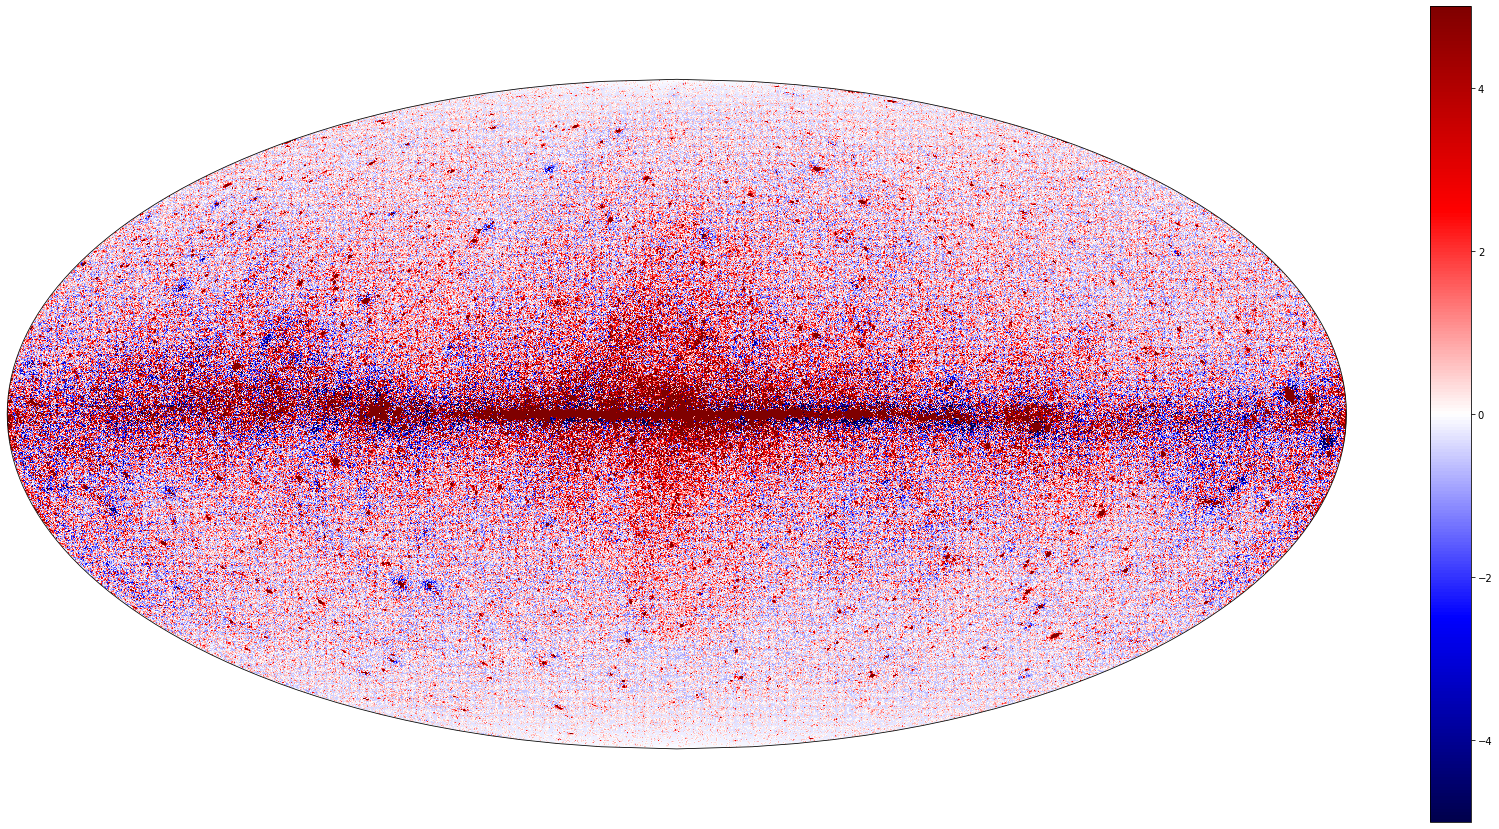

In [23]:
#diff = plt.imshow(numpy.subtract(count_data, 0.215*diffuse_model), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5))
#plt.colorbar(diff)
imshow_mollweide(numpy.subtract(count_data, 0.215*diffuse_model), plt.cm.seismic, colors.Normalize(vmin=-5,vmax=5))

In [31]:
#count_model = stripe(30, [13,14,15])*10 + 1
#data_model = 0.225*count_model #+ stripe(30, [13,14,15])*10 #+ 20*delta(30, 15, 15)
#count_data = poisson.rvs(data_model)
#a_model, hs_model, vs_model, ds_model = haar(count_model)
#a_data, hs_data, vs_data, ds_data = haar(count_data)

In [ ]:
a, hs, vs, ds = tipsh.haar_threshold_sphere(count_data, total_model, 0.001, fwer='uniform')

12 11 1 ******************************
alpha_j 0.001
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
11 -> Rejected 51490 56979 41308
12 10 2 ******************************
alpha_j 0.001
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
10 -> Rejected 103294 128957 67849
12 9 4 ******************************
alpha_j 0.001
sums
h threshold
small_left


In [20]:
count_rec = tipsh.inv_haar_sphere(a, hs, vs, ds)
print(sum(sum(count_data)), sum(sum(total_model)), sum(sum(count_rec)))

32568200 28592226.170959137 32568201.59307658


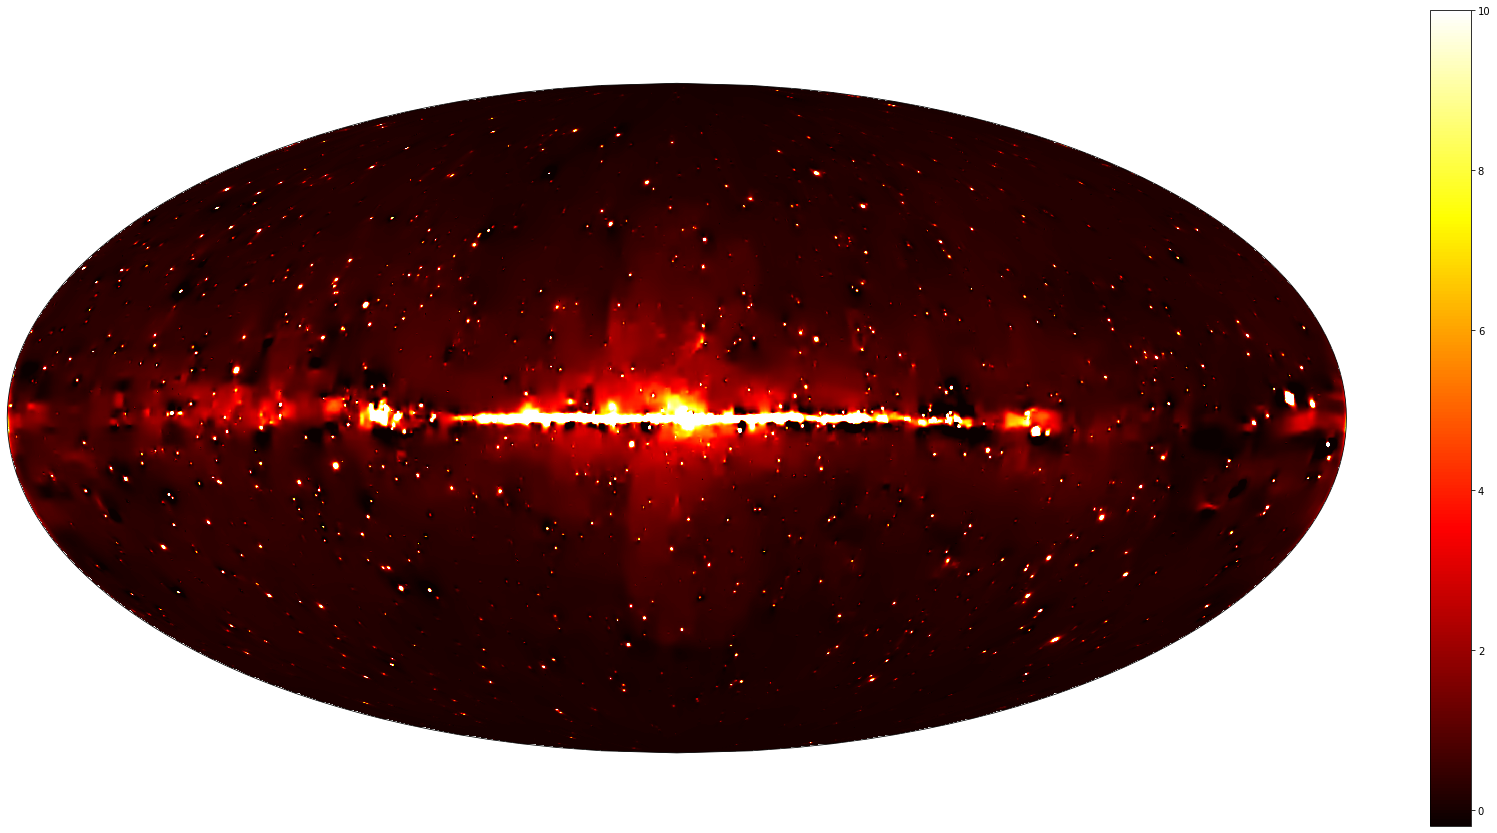

In [39]:
#fig, ax = plt.subplots()
#foo = plt.imshow(numpy.subtract(count_rec, total_model), cmap=plt.cm.hot, origin='lower', norm=colors.Normalize(vmin=-6,vmax=6), extent=(-180,180,-90,90))
fig, ax = imshow_mollweide(numpy.subtract(count_rec, total_model), plt.cm.hot, colors.Normalize(vmin=-0.2,vmax=10))
#fig, ax = imshow_mollweide(numpy.divide(numpy.subtract(count_rec, total_model), exp_data), plt.cm.hot, colors.SymLogNorm(linthresh=1e-15))
#fig, ax = imshow_mollweide(exp_data, plt.cm.hot, colors.Normalize())
#foo = plt.imshow(numpy.subtract(count_data, 0.225*diffuse_model), cmap=plt.cm.seismic, origin='lower', norm=colors.LogNorm())
#foo = plt.imshow(count_model[500:1300,1400:2200], origin='lower', cmap=plt.cm.magma, norm=colors.LogNorm(vmax=1000))
#foo = plt.imshow(diffuse_model, origin='lower', cmap=plt.cm.magma)
#foo = plt.imshow(numpy.subtract(count_model2, count_model), origin='lower', cmap=plt.cm.magma, norm=colors.Normalize(vmax=10))
#foo = plt.imshow(vs[0], origin='lower', cmap=plt.cm.magma)
#foo = plt.imshow(numpy.subtract(count_rec, count_model), cmap=plt.cm.magma, origin='lower')
#ax.contour(Lat, Lon, numpy.subtract(count_rec, total_model), levels, colors='g', transform=ccrs.PlateCarree())
#plt.colorbar(foo)
#plt.plot(numpy.subtract(count_data, count_rec)[0, :])

In [64]:
lon = numpy.arange(-180, 180, 0.1)
lat = numpy.arange(-90, 90, 0.1)
Lat, Lon = numpy.meshgrid(lon, lat)
levels = numpy.arange(-1, 5, 0.1)

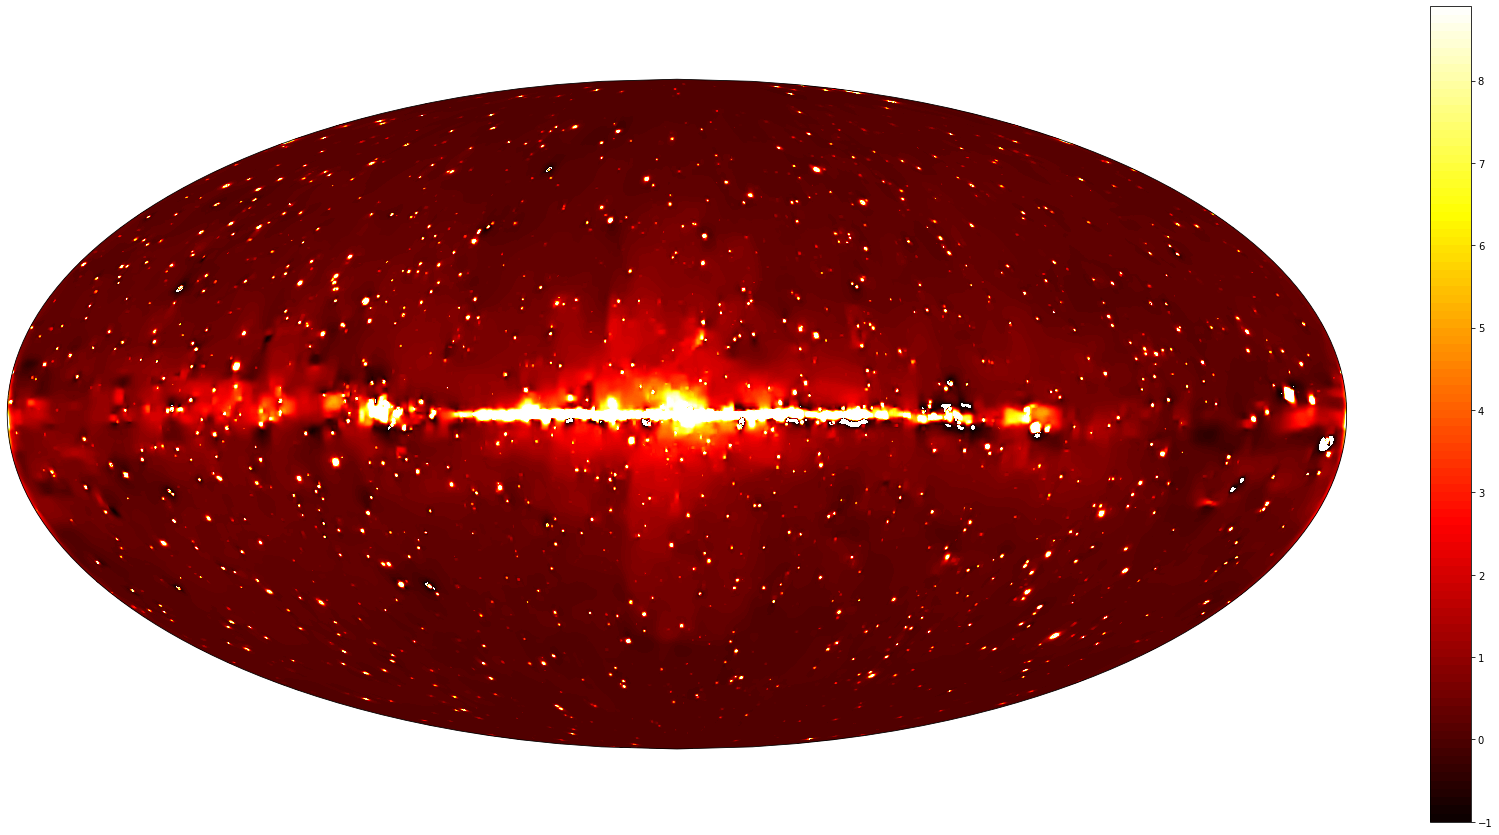

In [47]:
fig = plt.figure(figsize=(30, 15))
ax = plt.subplot(projection=ccrs.Mollweide())
foo = plt.contourf(Lat, Lon, numpy.subtract(count_rec, total_model), levels, cmap=plt.cm.hot, linewidths=0.3, transform=ccrs.PlateCarree())
plt.colorbar(foo)

In [398]:
numpy.logspace(-1,1)

array([ 0.1       ,  0.10985411,  0.12067926,  0.13257114,  0.14563485,
        0.15998587,  0.17575106,  0.19306977,  0.21209509,  0.23299518,
        0.25595479,  0.28117687,  0.30888436,  0.33932218,  0.37275937,
        0.40949151,  0.44984327,  0.49417134,  0.54286754,  0.59636233,
        0.65512856,  0.71968567,  0.79060432,  0.86851137,  0.95409548,
        1.04811313,  1.1513954 ,  1.26485522,  1.38949549,  1.52641797,
        1.67683294,  1.84206997,  2.02358965,  2.22299648,  2.44205309,
        2.6826958 ,  2.9470517 ,  3.23745754,  3.55648031,  3.90693994,
        4.29193426,  4.71486636,  5.17947468,  5.68986603,  6.25055193,
        6.86648845,  7.54312006,  8.28642773,  9.10298178, 10.        ])

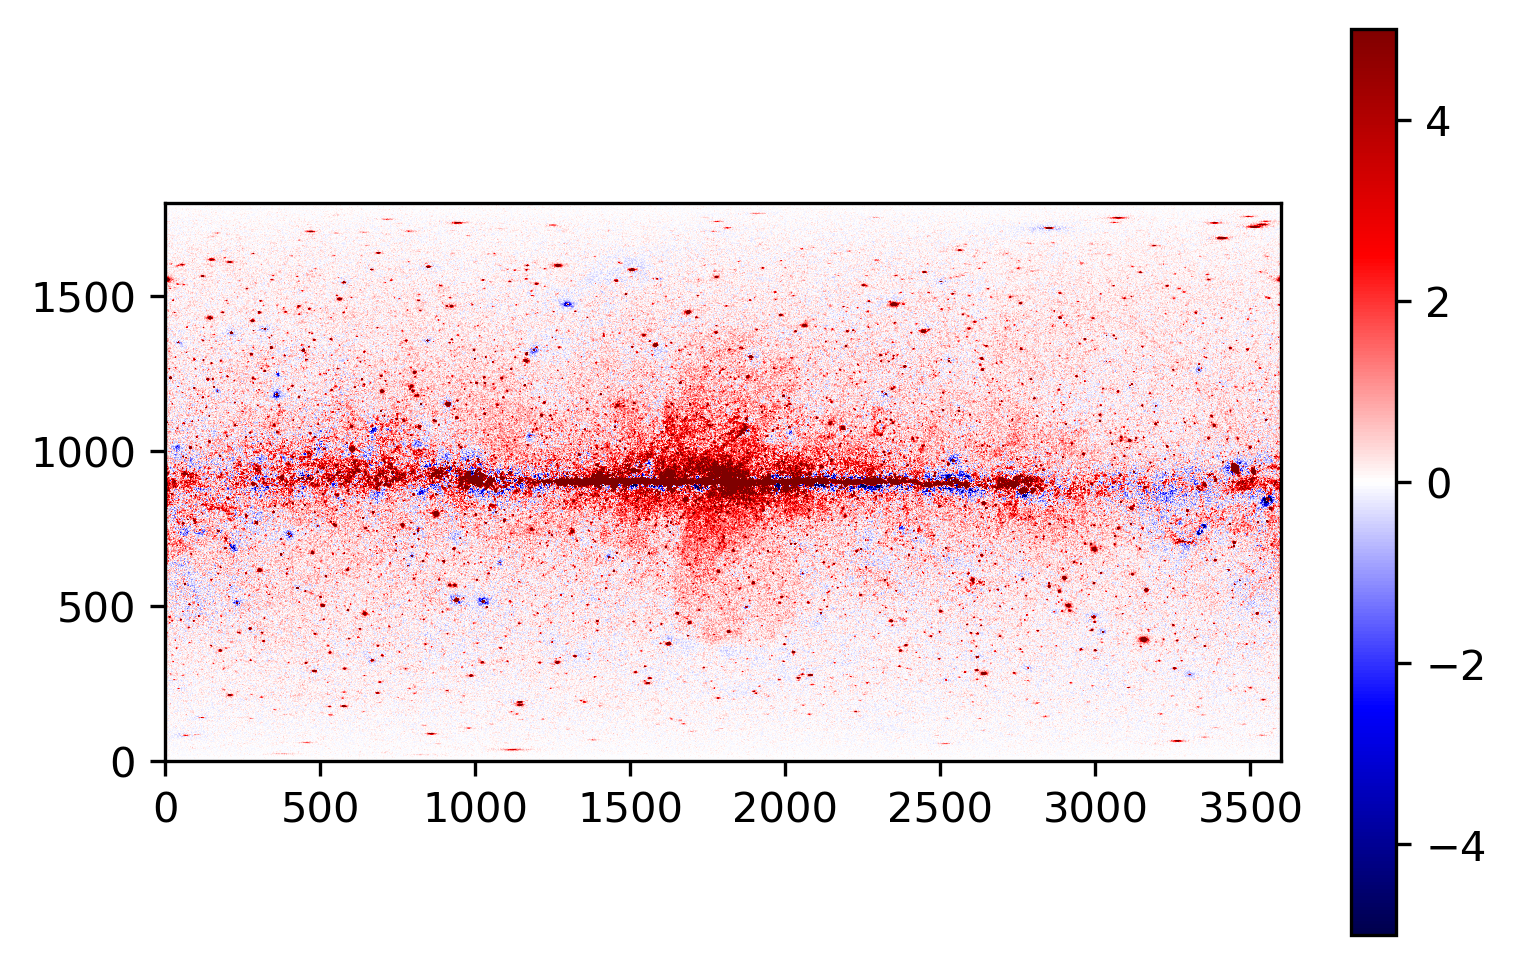

In [354]:
foo = plt.imshow(numpy.subtract(count_data, total_model), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5))
plt.colorbar(foo)

In [69]:
fig.savefig("2021-12-31_1_500_GeV_uniform_000001.png")

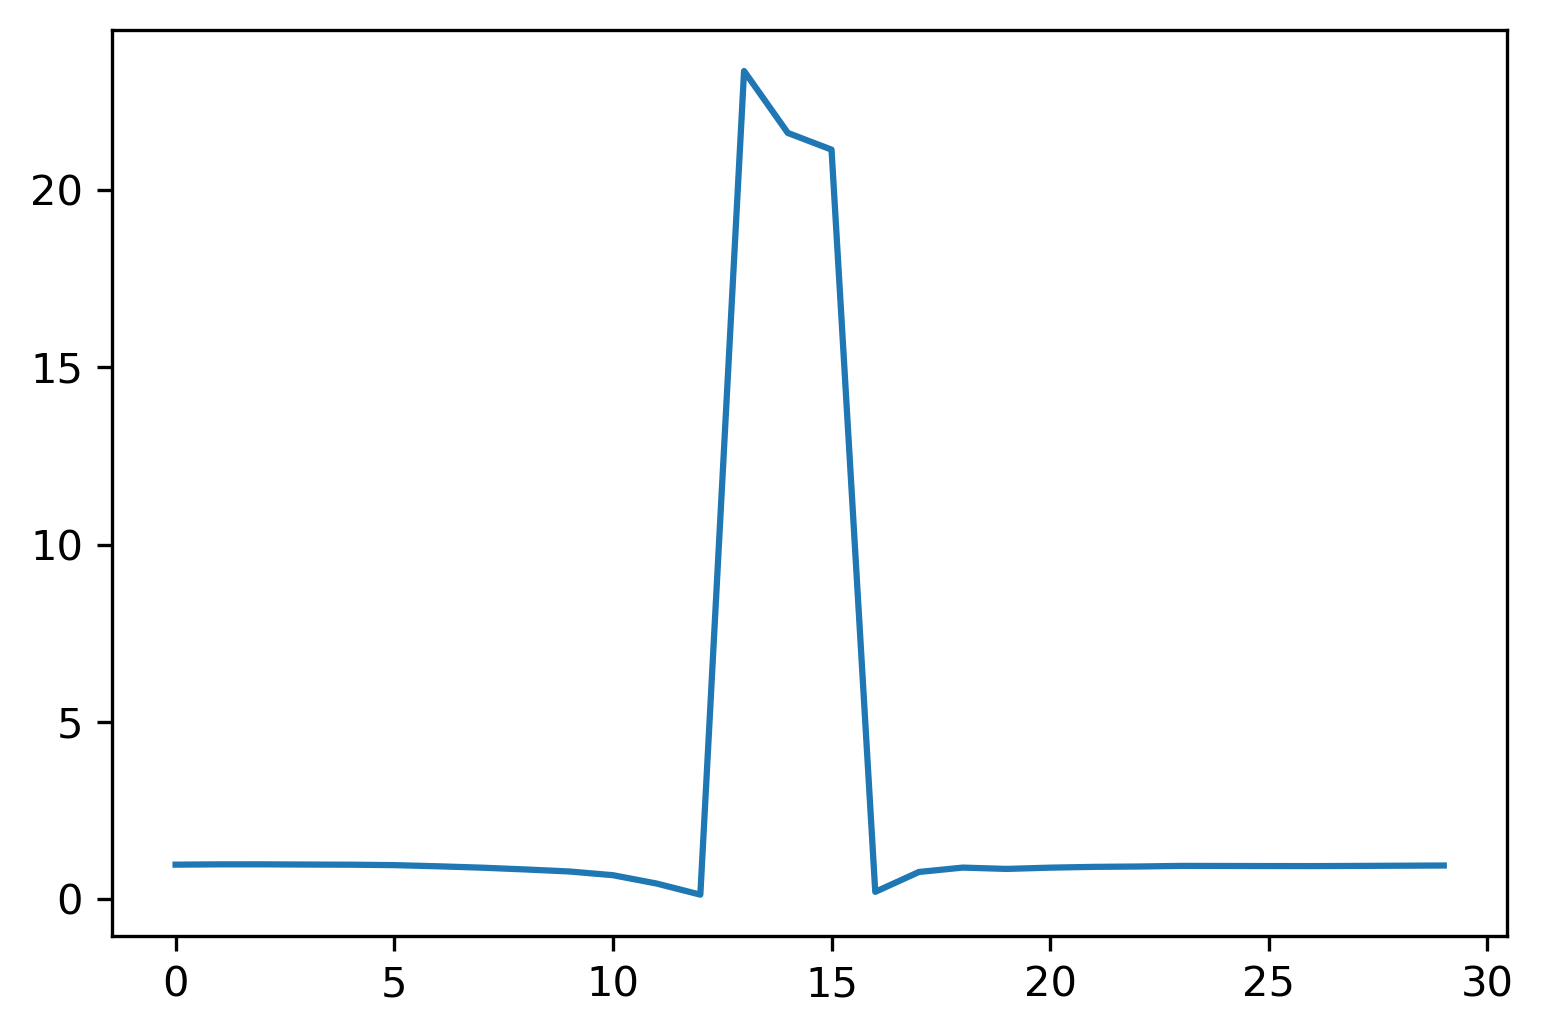

In [538]:
#plt.plot(numpy.subtract(count_rec, 0.225*count_model)[:, 1700])
plt.plot(count_rec[:, 15])

In [ ]:
numpy.savez_compressed("2022-01-01_uniform_000001.npz", a=a,hs=hs,vs=vs,ds=ds)

In [40]:
numpy.savez_compressed("count_rec_2022-01-01_uniform_000001.npz", count_rec=count_rec)

In [17]:
tmp = numpy.load("2022-01-01_uniform_000001.npz")
a = tmp['a']
hs = tmp['hs']
vs = tmp['vs']
ds = tmp['ds']

In [18]:
count_rec = numpy.load("count_rec_2022-01-01_uniform_000001.npz")['count_rec']

In [359]:
del a, hs, vs, ds

In [62]:
print(sum(sum(count_data)))
print(sum(sum(a)))
print(sum(sum(a2)))
print(sum(sum(a_rec)))
print(sum(sum(count_rec)))
sum(sum(a))/sum(sum(count_data))

32568200
65136400.0
130272792.0
65136396.0
32568200.0


2.0

In [418]:
#foo = plt.imshow(roll_sphere(dx, -1, 0), origin='lower')
#plt.colorbar(foo)
roll_sphere(roll_sphere(im, 1, 0), -1, 0)

1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0
9 0 9 0 0
10 1 0 9 5
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
9 0 9 0 -4
0 0 0 9 0
1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [188]:
a, h, v, d = haar_j(12, 11, count_data)

In [192]:
a10, _, _, _ = haar_j(12, 10, a)
a9, _, _, _ = haar_j(12, 9, a10)
a8, _, _, _ = haar_j(12, 8, a9)
a7, _, _, _ = haar_j(12, 7, a8)
a6, _, _, _ = haar_j(12, 6, a7)
a5, _, _, _ = haar_j(12, 5, a6)
a4, _, _, _ = haar_j(12, 4, a5)
a3, _, _, _ = haar_j(12, 3, a4)
a2, _, _, _ = haar_j(12, 2, a3)
a1, _, _, _ = haar_j(12, 1, a2)

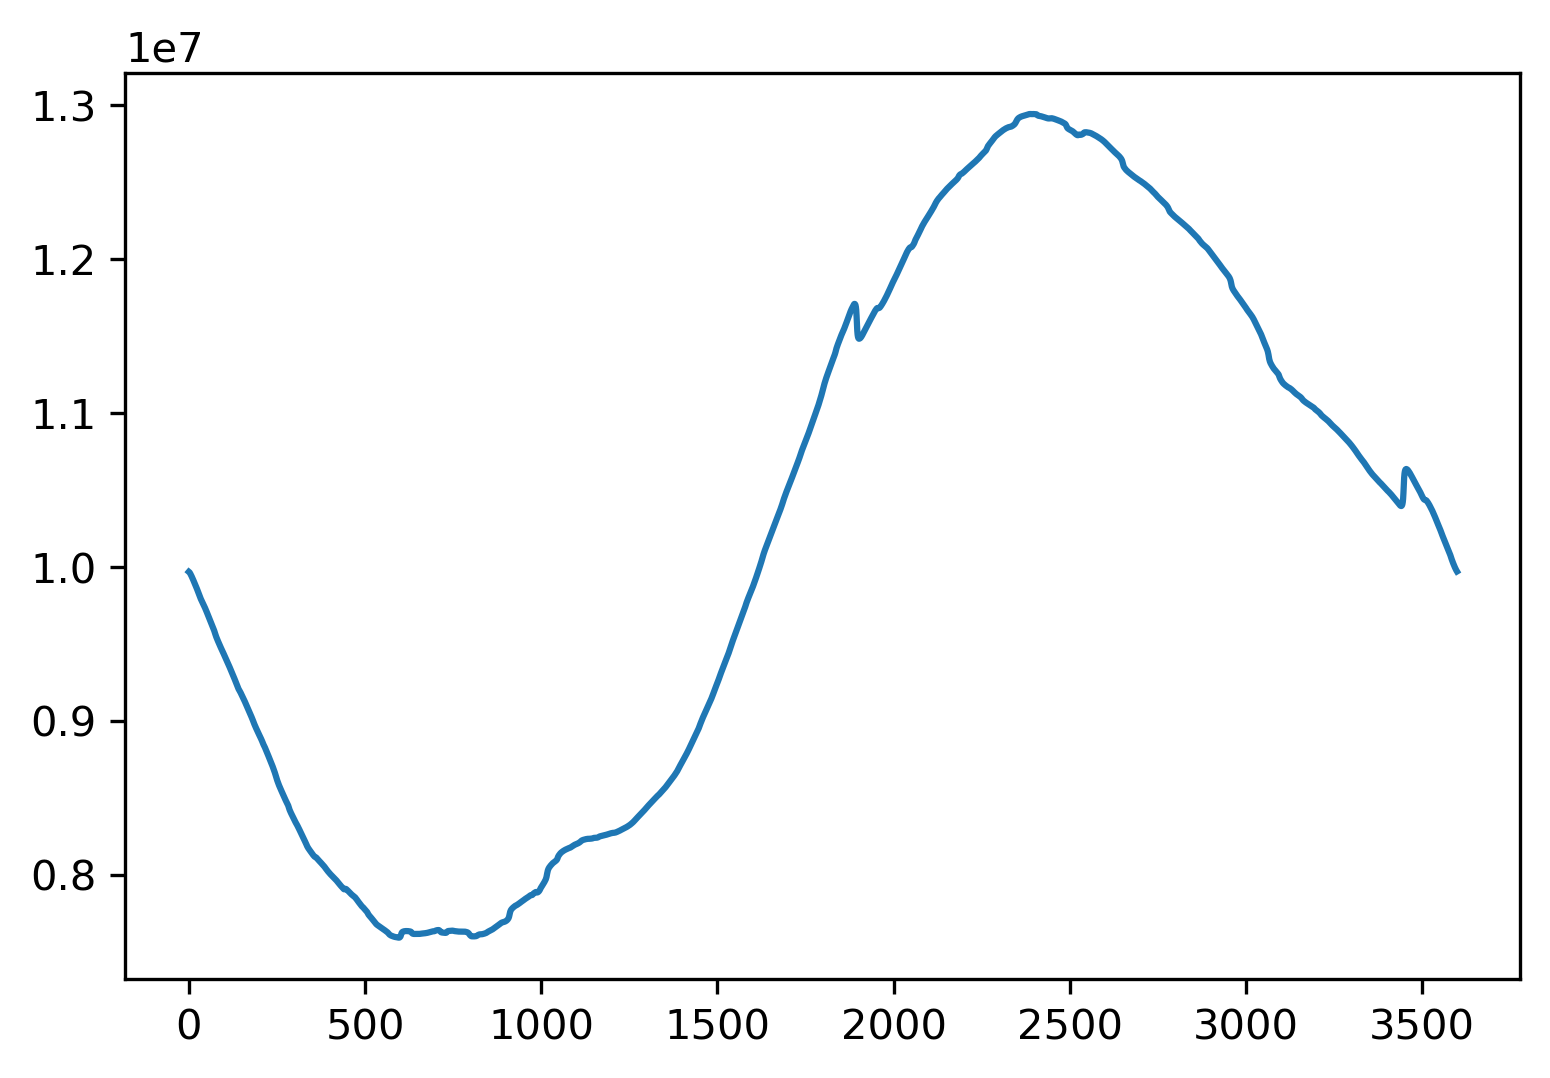

In [194]:
plt.plot(a1[900, :])

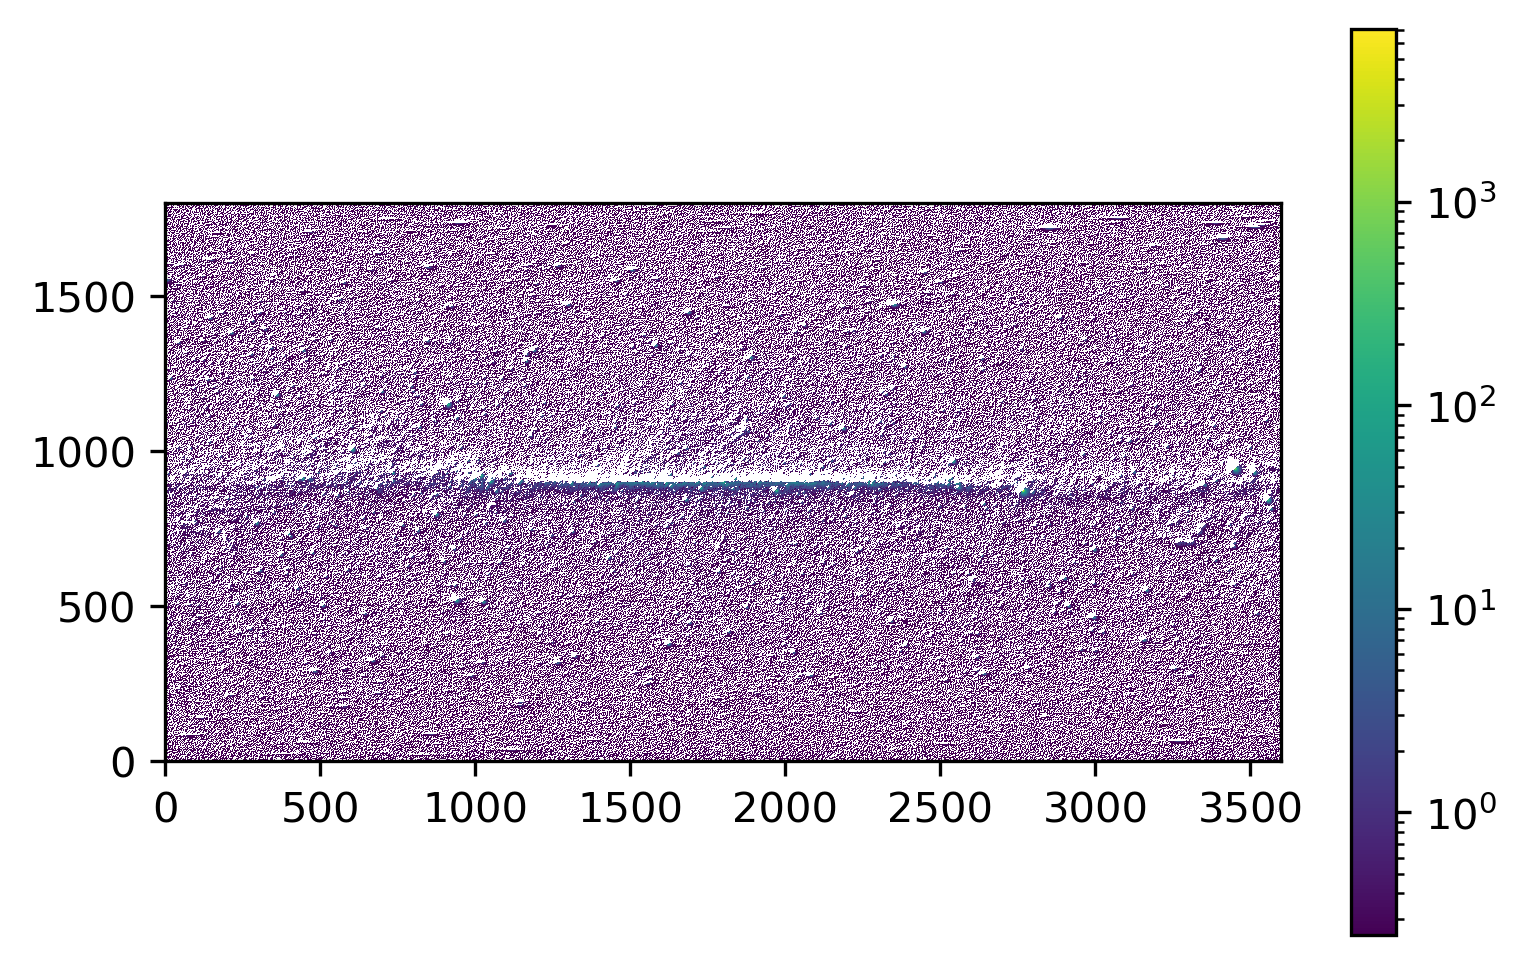

In [215]:
diff = plt.imshow(numpy.subtract(a / 4, count_data), origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
plt.colorbar(diff)

In [109]:
2**12

4096

In [16]:
ax.set_xlim(-180,180)

(-180.0, 180.0)

In [17]:
overlay = ax.get_coords_overlay('fk5')

In [18]:
overlay.grid(color='black', ls='dotted')